In [1]:
%cd /Volumes/ext_thumb/repos/PWC_net_tf

/Volumes/ext_thumb/repos/PWC_Net_tf


In [2]:
%load_ext autoreload
%autoreload 2

In [17]:
from sintel_dataset import get_sintel_disparity_dataset, get_sintel_path
from model import build_model, pyramid_compatible_shape
import matplotlib.pyplot as plt
import time

In [10]:
BATCH_SIZE = 1
NUM_PYRAMID_LEVELS = 8
PREDICT_LEVEL = 2
DATASET_SHAPE = (436, 1024) # h, w
MODEL_IN_SHAPE = pyramid_compatible_shape(DATASET_SHAPE, NUM_PYRAMID_LEVELS)

model = build_model(MODEL_IN_SHAPE, NUM_PYRAMID_LEVELS, PREDICT_LEVEL, True)
model.load_weights('pwc_net_ckpts/ckpt')

In [7]:
sintel_tfrecord_path = get_sintel_path(False)
_, ds = get_sintel_disparity_dataset(sintel_tfrecord_path, BATCH_SIZE, MODEL_IN_SHAPE, NUM_PYRAMID_LEVELS)

model input shape:  (512, 1024)


In [32]:
start_time = time.time()
d = model.predict(ds.take(1))
print('inference time: {:.2f}s'.format(time.time()-start_time))

inference time: 1.40s


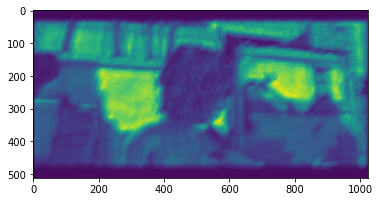

In [16]:
plt.imshow(d.squeeze())

# tflite conversion

In [33]:
import tensorflow as tf

In [34]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

In [35]:
lite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /var/folders/z5/qptv3csn3y5610hphsjgdf680000gn/T/tmp2h9ayx58/assets


In [37]:
lite_model_file = "tmp/pwd_net.tflite"
open(lite_model_file, "wb").write(lite_model)

In [ ]:
import time

import numpy as np
from PIL import Image
import tensorflow as tf # TF2

In [38]:
interpreter = tf.lite.Interpreter(
  model_path=lite_model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# NxHxWxC, H:1, W:2
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

In [47]:
tf.executing_eagerly()

True

In [51]:
feats, depth_gt = list(ds.take(1).as_numpy_iterator())[0]

In [55]:
feats['left_view'].shape

(1, 512, 1024, 3)

In [69]:
interpreter.set_tensor(input_details[0]['index'], feats['left_view'])
interpreter.set_tensor(input_details[1]['index'], feats['right_view'])

start_time = time.time()
nreps=100
for i in range(nreps):
    interpreter.invoke()
inf_time = (time.time()-start_time)/nreps
print('inference time: \n{:.3f}s\nfps: {:.1f}'.format(inf_time, 1/inf_time))

depth = interpreter.get_tensor(output_details[0]['index'])
depth = np.squeeze(depth)

inference time: 
0.354s
fps: 2.8


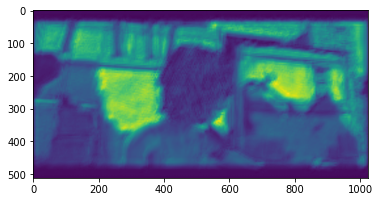

In [64]:
plt.imshow(depth)